In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
ab=pd.read_pickle('../../Data/AB.pkl')
aab=pd.read_pickle('../../Data/AAB.pkl')
abb=pd.read_pickle('../../Data/ABB.pkl')

In [3]:
def truncate_germline_names(data):    
    """
    Prepare gerlmine names s.t. the format matches the V/J region names provided names
    """
    beta_v_order=np.array(['1','2','3-1','4-1','5-1','6-1','7-1','4-2','6-2','3-2','4-3','6-3','7-2','8-1','5-2','6-4','7-3','8-2','5-3','9','10-1','11-1','12-1','10-2','11-2','12-2','6-5','7-4','5-4','6-6','7-5','5-5','6-7','7-6','5-6','6-8','7-7','5-7','6-9','7-8','5-8','7-9','13','10-3','11-3','12-3','12-4','12-5','14','15','16','17','18','19','20-1','21-1','22-1','23-1','24-1','25-1','26','27','28','29-1','30'])
    alpha_v_order=np.array(['1-1','1-2','2','3','4','5','6','7','8-1','9-1','10','11','12-1','8-2','8-3','13-1','12-2','8-4','8-5','13-2','14DV4','9-2','15','12-3','8-6','16','17','18','19','20','21','22','23DV6','24','25','26-1','8-7','27','28','29DV5','30','31','32','33','26-2','34','35','36DV7','37','38-1','38-2DV8','39','40','41'])
    beta_j_order=np.array(['1-1','1-2','1-3','1-4','1-5','1-6','2-1','2-2','2-2P','2-3','2-4','2-5','2-6','2-7'])
    alpha_j_order=np.array(list(map(str,range(1,62))))
    

    if 'A' in data:
        which='A'
        if 'V' in data:
            order=alpha_v_order
        else:
            order=alpha_j_order
    else:
        which='B'
        if 'V' in data:
            order=beta_v_order
        else:
            order=beta_j_order
         
    if '*' in data:
        value=data[data.find(which)+2:data.find('*')]
    else:
        value=data[data.find(which)+2:]
    
    return np.where(value==order)[0][0]

In [4]:
def cdr3_charge(cdr3):
    return cdr3.count('R')+cdr3.count('K')-cdr3.count('D')-cdr3.count('E')+20

In [5]:
def prepare_dfs(df):
    """
    Input full ab,aab, or abb df 
    Output alpha and beta dfs with columns "V", "J" and (amino acid) "CDR3"
    """
    if 'a2_V' in df.columns: #aab cell -> include both alpha chains
        alpha1=df[['a1_V','a1_J','a1_aaSeqCDR3','subject']]
        alpha2=df[['a2_V','a2_J','a2_aaSeqCDR3','subject']]
        alpha=np.vstack((alpha1,alpha2)) #combine alpha-alpha pairs into one df
        beta=np.array((df[['b1_V','b1_J','b1_aaSeqCDR3','subject']]))
    elif 'b2_V' in df.columns: #aab cell -> include both beta chains
        alpha=np.array((df[['a1_V','a1_J','a1_aaSeqCDR3','subject']]))
        beta1=df[['b1_V','b1_J','b1_aaSeqCDR3','subject']]
        beta2=df[['b2_V','b2_J','b2_aaSeqCDR3','subject']]
        beta=np.vstack((beta1,beta2)) #combine beta-beta pairs into one df
    else: #ab cell
        alpha=np.array((df[['a1_V','a1_J','a1_aaSeqCDR3','subject']]))
        beta=np.array((df[['b1_V','b1_J','b1_aaSeqCDR3','subject']]))   
    combined=pd.DataFrame(alpha,columns=['V','J','CDR3','subject']).append(pd.DataFrame(beta,columns=['V','J','CDR3','subject']))
    combined['Chain']=np.hstack((['Alpha']*alpha.shape[0],['Beta']*beta.shape[0]))
    combined.V=list(map(truncate_germline_names,combined.V))
    combined.J=list(map(truncate_germline_names,combined.J))
    combined['Charge']=list(map(cdr3_charge,combined.CDR3))
    combined['Length']=list(map(len,combined.CDR3))
    return combined

In [6]:
ab=prepare_dfs(ab)#.drop_duplicates()
aab=prepare_dfs(aab)#.drop_duplicates()
abb=prepare_dfs(abb)#.drop_duplicates()

In [7]:
def calculate_information(normal,inclusion):
    datapoints=np.unique(np.hstack((normal,inclusion)))
    count_matrix=MI_matrix=np.zeros((len(datapoints),2))
    for i,dataset in enumerate([normal,inclusion]):
        for x in dataset:
            count_matrix[np.where(x==datapoints)[0][0],i]+=1
    count_matrix=count_matrix/np.sum(count_matrix)
    for i in range(count_matrix.shape[0]):
        for j in range(count_matrix.shape[1]):
            joint=count_matrix[i,j]
            marginal_inclusion=np.sum(count_matrix[:,j])
            marginal_feature=np.sum(count_matrix[i,:])
            if marginal_inclusion>0 and marginal_feature>0 and joint>0:
                MI_matrix[i,j]=joint*np.log2(joint/(marginal_inclusion*marginal_feature))
    return np.sum(MI_matrix)

In [8]:
def finite_sampling_correction(normal,inclusion):
    info=[]
    value=[]
    for sample_size in np.arange(0.1,1,.02):
        for bootstraps in range(10):
            info.append(calculate_information(normal.sample(frac=sample_size),inclusion.sample(frac=sample_size)))
            value.append(sample_size)
    fit=np.polyfit(1/np.array(value),info,deg=2)
    p = np.poly1d(fit)
    return p(0)#low,intercept,high

In [9]:
data=[]
for bootstraping in range(10):
    aab_subsample=aab.sample(frac=0.8)
    abb_subsample=abb.sample(frac=0.8)
    ab_subsample=ab.sample(frac=0.8)
    for feature in ['V','J','Charge','Length']:
        for i,inclusion_dataset in enumerate([aab_subsample,abb_subsample]):
            for chain in ['Alpha','Beta']:
                normal=ab_subsample[(ab_subsample.Chain==chain)][feature]
                inclusion=inclusion_dataset[(inclusion_dataset.Chain==chain)][feature]
                data.append(np.hstack((feature,chain,i,finite_sampling_correction(normal,inclusion))))

In [10]:
data=pd.DataFrame(np.vstack(data),columns=['Feature','Chain','Dataset','y'])#'low','y','high'])
data['Hue']=data.Chain+data.Dataset.astype(str)
#data[['low','y','high']]=data[['low','y','high']].astype(float)
data.y=data.y.astype(float)

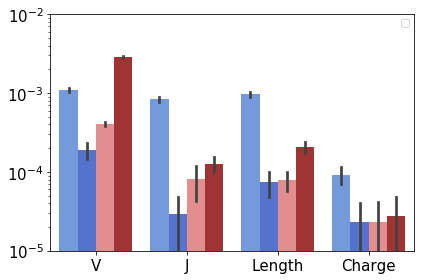

In [11]:
sns.barplot(x='Feature',y='y',hue='Hue',data=data,order=['V','J','Length','Charge'],palette=['cornflowerblue','royalblue','lightcoral','firebrick'],ci='sd')
plt.yscale('log')
plt.ylim([1e-5,1e-2])
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend('')
